# Proyecto Final — Tamizaje de Diabetes con Deep Learning (HITL)
**Equipo:** Equipo 1 **Noelia Blanco** **María Eugenia Puchkariov** **Gonzalo del Priore**• **Fecha:** 29-08-2025

> Proyecto de Maestría que **aplica el ciclo de vida completo** de un proyecto DL: desde **concepción estratégica** (arquetipo **Software 2.0 + HITL**), hasta **prototipo funcional** en Streamlit


# 1. Introducción, concepción estratégica y caracterización del problema

## 1.1 Contexto y motivación (OMS)
La diabetes mellitus es un problema de salud pública por su alta prevalencia, mortalidad evitable y costos asociados. Informes de la OMS subrayan la necesidad de **detección temprana** y de fortalecer el **primer nivel de atención** con herramientas costo-efectivas y sistemas de información confiables. En este marco, un **tamizaje algorítmico** que priorice sensibilidad puede orientar mejor las derivaciones a confirmación diagnóstica y el seguimiento oportuno.

## 1.2 Problema y usuarios
**Problema.** Dadas variables clínicas simples, estimar la **probabilidad de diabetes** (clasificación binaria) para apoyar el **tamizaje** (no es diagnóstico definitivo).  
**Usuarios.** Equipos de atención primaria y programas de prevención/seguimiento (uso vía formulario web o integración liviana con HCE).  
**Valor.** Aumentar la **sensibilidad** del tamizaje con una tasa de **falsos positivos** gestionable, estandarizar criterios de derivación y aportar **trazabilidad** de decisiones.

## 1.3 Dataset de trabajo (Pima Indians Diabetes)
Usamos el dataset **Pima Indians Diabetes** (≈768 casos; mujeres ≥21 años), con 8 predictores y la variable objetivo `Outcome` (1/0).  
**Variables:** `Pregnancies`, `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, `BMI`, `DiabetesPedigreeFunction`, `Age`.  
**Calidad y preprocesamiento.** El CSV contiene **“ceros imposibles”** en variables fisiológicas (p. ej., presión 0); se recodifican a `NaN` e **imputan** (mediana). Luego **estandarizamos** y realizamos **split estratificado** para preservar la prevalencia.  
**Implicaciones.** El sesgo poblacional (mujeres Pima) exige cautela al extrapolar; el **desbalance** motiva métricas centradas en *recall* y técnicas de balanceo.

## 1.4 Concepción estratégica y arquetipo
Adoptamos **Software 2.0 + Human-in-the-Loop (HITL)**: el modelo **asiste** la decisión y los **casos cercanos al umbral** se derivan a revisión clínica. Esto combina **alto impacto/bajo costo** (variables accesibles, flujo simple) y alinea el **punto operativo** con el **riesgo sanitario** (**FN ≫ FP**).

## 1.5 Métricas y política de coste-error
- **Métrica primaria:** **F₂** (pondera *recall*).  
- **Prueba de estrés:** **F₅** (sensibilidad aún más alta).  
- **Métrica secundaria:** **AUPRC** (adecuada en desbalance).  
- **Selección de umbral:** por **Fβ** y por **coste FN:FP** (escenarios 3:1, 5:1, 7:1) para alinear con prioridades clínicas y restricciones presupuestarias.

## 1.6 ¿Por qué Deep Learning aquí?
- **No linealidad e interacciones** (p. ej., `Glucose × BMI × Age`) que superan lo lineal.  
- **Capacidad de representación:** **MLP/DNN** y **autoencoders** extraen **embeddings** útiles en tabulares con colinealidades/ruido.  
- **Control del punto operativo:** `class_weight`/SMOTE en *train*, **calibración** (Platt/Isotónica) y **umbrales** por Fβ/coste para ajustar el sistema a **FN bajos**.  
- **Mantenibilidad (Software 2.0):** facilita reentrenos, monitoreo de **drift** y ampliación de datos en un único *pipeline*.  
_Nota:_ Se incluye **Regresión Logística** como *baseline* interpretable. No se usan **CNN/RNN/Transformers** por tratarse de un **tabular estático**.

## 1.7 Preguntas clave (marco de estructuración)
- **¿Qué decisión habilita el modelo?** Priorizar confirmación diagnóstica y seguimiento; **minimizar FN**.  
- **¿Qué datos y calidad?** Auditoría de “ceros imposibles”, **imputación**, **escalado**, **split estratificado**, desbalance.  
- **¿Cómo medimos éxito?** **F₂/F₅**, **AUPRC**, **calibración** (Brier/ECE), **IC95% por bootstrap**, análisis por **subgrupos** (edad/BMI).  
- **¿Riesgos/mitigaciones?** Sobreajuste (CV K=5), sesgo poblacional (validez externa), *dataset shift* (monitoreo y **recalibración**).  
- **¿Operación?** **Prototipo** (Streamlit), *slider* de umbral, **banda HITL**, *logging* básico y versionado.

## 1.8 Objetivos y alcance
**Objetivo general.** Diseñar, implementar y **validar** un *pipeline* de DL para **tamizaje de riesgo de diabetes** con foco en **bajos FN**, **calibración** de probabilidades, **explicabilidad** y **prototipo funcional**.  
**Específicos.** (i) Preparación de datos (imputación, escalado, balanceo); (ii) Modelado comparativo (**LR**, **MLP** y **AE→FT**); (iii) Entrenamiento robusto (early stopping, **CV K=5**, *tuning* ligero); (iv) Evaluación (F₂/F₅, AUPRC, umbrales por coste, **IC95%**); (v) **Prototipo HITL** listo para interacción con usuarios clínicos.


# 2. Ciclo de vida aplicado (planificación → datos → modelado → evaluación → prototipo)

El desarrollo del proyecto se estructuró siguiendo el ciclo de vida completo de un sistema de Deep Learning, en el cual se integraron de forma coherente las fases de planificación, preparación de datos, modelado, evaluación y prototipado. Este abordaje no se limitó al entrenamiento de modelos, sino que buscó garantizar trazabilidad, robustez y relevancia clínica, con miras a la integración en un entorno real de atención primaria. A continuación, se detalla cada etapa.

## 2.1 Planificación estratégica

La planificación constituyó el punto de partida para acotar el problema, definir objetivos y establecer criterios de éxito.  
- **Alcance**: el sistema se diseñó para estimar la probabilidad de diabetes en base a variables clínicas simples y de bajo costo, con el fin de apoyar la priorización de estudios confirmatorios.  
- **Métricas operativas**: se definió la F₂ como métrica primaria por su énfasis en la sensibilidad; la F₅ como prueba de estrés en escenarios de máxima exigencia de recall; y el AUPRC como métrica secundaria, adecuada ante el desbalance de clases observado.  
- **Supuestos y riesgos**: se asumió la disponibilidad de datos tabulares estructurados y de calidad moderada; los principales riesgos identificados fueron el sesgo poblacional (dataset Pima), el sobreajuste en un dataset reducido y la dificultad de calibrar probabilidades.  
- **Criterios de éxito**: alcanzar FN dentro de límites clínicamente aceptables, AUPRC ≥ 0.65, estabilidad en validación cruzada (K=5) y disponibilidad de un prototipo funcional que demuestre la viabilidad de uso.  

## 2.2 Preparación y procesamiento de datos

El dataset empleado (Pima Indians Diabetes) presenta limitaciones inherentes, pero resulta adecuado como prueba de concepto. Las principales etapas fueron:  
- **Auditoría de calidad**: identificación de valores fisiológicamente imposibles (p. ej., presión arterial o glucosa = 0), recodificados como NaN.  
- **Imputación**: reemplazo de valores faltantes mediante la mediana, garantizando robustez frente a outliers.  
- **Estandarización**: aplicación de z-score para estabilizar gradientes en el entrenamiento de redes neuronales.  
- **Split estratificado**: división en train/test preservando la proporción de positivos (~35%), de modo de reflejar la prevalencia real y evitar sesgos en el rendimiento.  

## 2.3 Estrategias de balanceo y aumento

Dado el desbalance de clases, se aplicaron técnicas complementarias:  
- **Pesos por clase** (*class weights*), para penalizar errores en la clase minoritaria.  
- **Oversampling sintético (SMOTE)**, aplicado únicamente sobre el set de entrenamiento.  
- **Regularización en el modelo**: incorporación de *Gaussian Noise* en capas densas, lo cual simula la variabilidad clínica y refuerza la capacidad de generalización.  

## 2.4 Modelado y arquitecturas evaluadas

Se adoptó una estrategia comparativa, evaluando diferentes arquitecturas con fines de benchmarking y optimización:  
- **Regresión Logística (baseline)**: seleccionada por su interpretabilidad y valor como punto de referencia.  
- **MLP (Multilayer Perceptron)**: arquitectura básica de red neuronal densa, apta para datos tabulares.  
- **DNN profunda**: red más compleja con varias capas ocultas, *Batch Normalization* y *Dropout*, destinada a explorar mejoras de capacidad representacional.  
- **Transfer Learning + Fine-Tuning (Autoencoder)**: preentrenamiento mediante un autoencoder para extraer representaciones latentes, seguido de un clasificador y ajuste fino del encoder. Esta técnica buscó explotar las correlaciones internas de los datos y mejorar la discriminación en contextos de alta colinealidad.  

## 2.5 Evaluación y validación

El proceso evaluativo fue concebido de manera rigurosa y clínica:  
- **Métricas primarias y secundarias**: F₂ y F₅ para sensibilidad y AUPRC para rendimiento en desbalance.  
- **Curvas de desempeño**: curvas de precisión-recall y matrices de confusión calculadas en umbrales óptimos.  
- **Calibración**: estimada mediante Brier Score y Expected Calibration Error (ECE), aplicando además calibración sigmoide (Platt) e isotónica.  
- **Validación robusta**: validación cruzada estratificada (K=5) y bootstrap para obtener intervalos de confianza al 95% de las métricas.  

## 2.6 Explicabilidad y auditoría clínica

El proyecto incorporó mecanismos de explicabilidad para favorecer la confianza y auditoría por parte de profesionales de la salud:  
- **Permutation Importance**: permitió identificar el peso relativo de cada variable clínica en las predicciones.  
- **LIME y SHAP (opcional)**: empleados para explicar casos individuales y analizar patrones globales de importancia, reforzando la transparencia del sistema.  

## 2.7 Optimización de hiperparámetros

Se exploró una optimización ligera mediante **Keras Tuner**, ajustando unidades y tasas de dropout en arquitecturas densas. La búsqueda se limitó a configuraciones rápidas dada la escala del dataset, priorizando eficiencia sobre exhaustividad.  

## 2.8 Prototipo funcional (Streamlit)

La fase final consistió en trasladar el modelo a un prototipo interactivo, concebido bajo el arquetipo Software 2.0 + Human-in-the-Loop (HITL):  
- **Aplicación en Streamlit** (`app.py`).  
- **Interacción con el usuario**: formulario web con entrada manual de variables, slider para umbral de decisión y configuración de la banda HITL (±0.03).  
- **Resultados**: cálculo de probabilidad, clasificación automática o derivación a revisión en casos fronterizos.  
- **Valor agregado**: la interfaz demuestra cómo un sistema académico puede integrarse en flujos clínicos reales, facilitando escalabilidad y aceptabilidad por parte de equipos médicos.  




# 3. Setup del entorno

**Reproducibilidad.** Fijamos `SEED=42` en NumPy y TensorFlow; registramos versiones de `numpy`, `pandas`, `tensorflow`.

**Dependencias.**
- `imbalanced-learn` para **SMOTE**.
- `keras-tuner` (opcional) para **HPO** en redes densas.

**Paquetes principales.** `numpy`, `pandas`, `matplotlib`, `scikit-learn` (preprocesado, métricas, calibración), `tensorflow/keras` (capas densas, BN, Dropout).

> *Nota:* ocultamos *warnings* no críticos para una salida limpia del cuaderno.

In [1]:
# === 3) Setup ===
!pip -q install imbalanced-learn keras-tuner >/dev/null

import os, sys, json, warnings, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (fbeta_score, average_precision_score, precision_recall_curve,
                             auc, confusion_matrix, brier_score_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

warnings.filterwarnings("ignore")
SEED = 42
np.random.seed(SEED); tf.random.set_seed(SEED)

print("Versions ➜ numpy", np.__version__, "| pandas", pd.__version__, "| tf", tf.__version__)


Versions ➜ numpy 2.0.2 | pandas 2.2.2 | tf 2.19.0


# 4. Datos y preprocesamiento

**Dataset.** *Pima Indians Diabetes* (~768 observaciones; 8 predictores; etiqueta binaria `Outcome`/`diabetes`).

**Limpieza.** Reemplazamos **valores fisiológicamente imposibles** (p.ej., `Glucose=0`) por `NaN` → **imputación** (mediana).

**Estandarización.** Escalado **z-score** para estabilizar gradientes en redes.

**Partición.** `train_test_split` **estratificado** (80/20), preservando prevalencia.

**Desbalance.** Calculamos `class_weight` (mayor peso a la clase 1) y documentamos distribución.

**Comentario clínico.** Dataset sesgado (mujeres Pima) → cautela al extrapolar y foco en **recall**.

Train/Test: (614, 8) (154, 8) | class_weight: {np.int64(0): np.float64(0.7675), np.int64(1): np.float64(1.4345794392523366)}


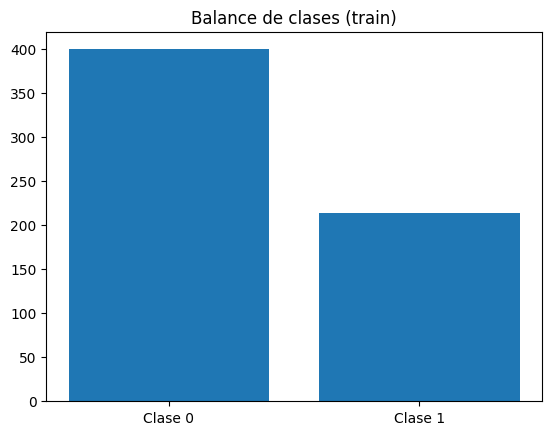

In [2]:
# === 4) Datos & preprocesamiento ===
candidates = ["diabetes.csv", "./data/diabetes.csv", "/mnt/data/diabetes.csv"]
csv_path = next((p for p in candidates if Path(p).exists()), None)
if csv_path is None:
    raise FileNotFoundError("No se encontró 'diabetes.csv'. Sube el archivo o ajusta la ruta.")

df = pd.read_csv(csv_path)
df.columns = [c.strip().lower() for c in df.columns]

if 'outcome' in df.columns:
    y = df['outcome'].astype(int).values; X = df.drop(columns=['outcome']).copy()
elif 'diabetes' in df.columns:
    y = df['diabetes'].astype(int).values; X = df.drop(columns=['diabetes']).copy()
else:
    raise ValueError("No se encuentra la columna objetivo ('Outcome'/'diabetes').")

feature_names = list(X.columns)

# Zeros imposibles -> NaN en biométricas
for c in [c for c in ['glucose','bloodpressure','skinthickness','insulin','bmi'] if c in X.columns]:
    X.loc[X[c]==0, c] = np.nan

# Split estratificado
Xtr_df, Xte_df, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

# Imputación + Escalado
imp = SimpleImputer(strategy='median'); scaler = StandardScaler()
Xtr = scaler.fit_transform(imp.fit_transform(Xtr_df))
Xte = scaler.transform(imp.transform(Xte_df))
d = Xtr.shape[1]

# class_weight
classes = np.unique(ytr); cw = compute_class_weight('balanced', classes=classes, y=ytr)
class_weight = dict(zip(classes, cw))

print("Train/Test:", Xtr.shape, Xte.shape, "| class_weight:", class_weight)

# Visual rápido: balance de clases en train
plt.figure()
counts = pd.Series(ytr).value_counts().sort_index()
plt.bar(['Clase 0','Clase 1'], counts.values)
plt.title('Balance de clases (train)'); plt.show()



## División de los datos
Se realizó un *split* estratificado (80% entrenamiento / 20% prueba), preservando la proporción de casos positivos (~35%). De este modo, se obtuvieron **614 observaciones para entrenamiento** y **154 para prueba**, con el objetivo de reflejar fielmente la distribución real de la población.


## Manejo del desbalance de clases
Dado que el dataset presenta un desbalance entre las clases, se calcularon pesos de clase (*class weights*) para equilibrar la influencia de cada categoría durante el entrenamiento. Los resultados fueron:  
- **Clase 0 (no diabetes)**: peso 0.77  
- **Clase 1 (diabetes)**: peso 1.43  

Esto significa que los errores en la predicción de la clase positiva (diabetes) tienen casi el doble de penalización que los errores en la clase negativa, priorizando la reducción de **falsos negativos**, lo cual resulta crítico en un contexto clínico.

## Visualización del balance de clases
El gráfico de barras generado mostró de manera clara el desbalance:  
- **Clase 0 (no diabetes)**: aproximadamente 400 registros en el conjunto de entrenamiento.  
- **Clase 1 (diabetes)**: aproximadamente 214 registros en el conjunto de entrenamiento.  

Este hallazgo justifica la aplicación de técnicas adicionales de corrección, como el **sobremuestreo sintético (SMOTE)** y la regularización en redes neuronales, con el fin de evitar que el modelo favorezca a la clase mayoritaria.




# 5. Balanceo en entrenamiento (SMOTE)

**Motivación.** Reducir sesgo hacia la clase mayoritaria y ayudar a la red a **detectar positivos**.

**Procedimiento.** Aplicamos **SMOTE** (k=5) **solo en train** → `Xtr_bal`, `ytr_bal` con distribución equilibrada.

**Resultado esperado.** Mejor **recall** sin replicar casos, a costa de potencial ruido sintético (monitorear con validación).


In [3]:
# === 5) Balanceo en TRAIN (SMOTE) ===
USE_SMOTE = True
if USE_SMOTE:
    sm = SMOTE(random_state=SEED, k_neighbors=5)
    Xtr_bal, ytr_bal = sm.fit_resample(Xtr, ytr)
    print('SMOTE: Antes:', Xtr.shape, np.bincount(ytr), '| Después:', Xtr_bal.shape, np.bincount(ytr_bal))
else:
    Xtr_bal, ytr_bal = Xtr, ytr


SMOTE: Antes: (614, 8) [400 214] | Después: (800, 8) [400 400]


## Consideraciones

Dado que el conjunto de entrenamiento presentaba un desbalance entre clases (400 casos negativos frente a 214 positivos), se aplicó la técnica **SMOTE (Synthetic Minority Oversampling Technique)**. Este método genera nuevas instancias sintéticas de la clase minoritaria a partir de sus vecinos más cercanos, en lugar de replicar casos existentes. Con ello, se busca reducir el sesgo del modelo hacia la clase mayoritaria y mejorar su capacidad para detectar casos positivos.


### Resultados
- **Antes de SMOTE**: 614 registros en entrenamiento, con distribución [400 negativos, 214 positivos].  
- **Después de SMOTE**: 800 registros en entrenamiento, con distribución equilibrada [400 negativos, 400 positivos].  

Este resultado muestra que SMOTE **incrementó la clase minoritaria en 186 casos sintéticos**, logrando una distribución balanceada entre clases. Esto permitirá que el modelo entrene con un sesgo menor hacia la clase negativa, priorizando la correcta detección de pacientes con riesgo de diabetes (reducción de falsos negativos).



# 6. Modelado y entrenamiento

**Regresión Logística (LR).**
- Variante con `class_weight='balanced'` sobre *train* original.
- Variante entrenada sobre *train* con **SMOTE**.

**MLP (red densa).**
- Arquitectura ligera: `Dense(32) → Dropout(0.2) → Dense(16) → Dense(1, sigmoid)`.
- `Adam(1e-3)`, **Early Stopping**, *validation_split*.

**DNN profunda.**
- `GaussianNoise(0.02)` + bloques `Dense + BatchNorm + Dropout` y concat de caminos intermedios.

**TL+FT (Autoencoder).**
- AE (pérdida MSE) aprende **embedding** (capa `code`).
- Encoder + *head* para clasificación y **fine-tuning**.

**Salida de este bloque.** Probabilidades en **test**:
`ys_lr`, `ys_lr_s`, `ys_mlp`, `ys_deep`, `ys_tlft` → insumo para todas las métricas posteriores.


In [4]:
# === 6) Modelos: LR / MLP / DNN profunda / TL+FT ===
def build_mlp(input_dim:int):
    m = keras.Sequential([
        layers.Input((input_dim,)),
        layers.Dense(32,'relu'),
        layers.Dropout(0.2),
        layers.Dense(16,'relu'),
        layers.Dense(1,'sigmoid')
    ])
    m.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy')
    return m

def build_deep_dnn(input_dim:int):
    inp = layers.Input(shape=(input_dim,))
    x   = layers.GaussianNoise(0.02)(inp)  # aumento ligero
    x   = layers.Dense(128,'relu')(x); x = layers.BatchNormalization()(x); x = layers.Dropout(0.3)(x)
    h1  = layers.Dense(64,'relu')(x);  h1 = layers.BatchNormalization()(h1); h1 = layers.Dropout(0.3)(h1)
    h2  = layers.Dense(64,'relu')(h1); h2 = layers.BatchNormalization()(h2); h2 = layers.Dropout(0.3)(h2)
    x   = layers.Concatenate()([h1,h2])
    x   = layers.Dense(32,'relu')(x); x = layers.BatchNormalization()(x); x = layers.Dropout(0.2)(x)
    out = layers.Dense(1,'sigmoid')(x)
    m   = keras.Model(inp,out); m.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy')
    return m

def build_autoencoder(input_dim:int, code_dim:int=8):
    inp = layers.Input(shape=(input_dim,))
    x   = layers.Dense(32,'relu')(inp); x = layers.Dropout(0.1)(x)
    code= layers.Dense(code_dim,'relu',name='code')(x)
    x   = layers.Dense(32,'relu')(code)
    out = layers.Dense(input_dim,'linear')(x)
    ae  = keras.Model(inp,out); ae.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')
    return ae

def extract_encoder(ae): return keras.Model(ae.input, ae.get_layer('code').output)
def build_head_from(encoder):
    inp = layers.Input(shape=(encoder.input_shape[1],)); x = encoder(inp)
    x   = layers.Dense(16,'relu')(x); out = layers.Dense(1,'sigmoid')(x)
    m   = keras.Model(inp,out); m.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy'); return m
def fine_tune(encoder):
    inp = layers.Input(shape=(encoder.input_shape[1],)); x = encoder(inp)
    x   = layers.Dense(16,'relu')(x); out = layers.Dense(1,'sigmoid')(x)
    m   = keras.Model(inp,out); m.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy'); return m

E_MLP,E_AE,E_HEAD,E_TLFT = 200, 120, 120, 120
cb=[keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True)]

# Entrenamiento
# LR
lr_bal   = LogisticRegression(max_iter=1000, class_weight='balanced').fit(Xtr, ytr)
lr_smote = LogisticRegression(max_iter=1000).fit(Xtr_bal, ytr_bal)

# MLP
mlp = build_mlp(Xtr.shape[1])
mlp.fit(Xtr_bal, ytr_bal, validation_split=0.2, epochs=E_MLP, batch_size=32,
        class_weight=class_weight, callbacks=cb, verbose=0)

# DNN
deep_dnn = build_deep_dnn(Xtr.shape[1])
deep_dnn.fit(Xtr_bal, ytr_bal, validation_split=0.2, epochs=E_MLP, batch_size=32,
             class_weight=class_weight, callbacks=cb, verbose=0)

# TL+FT
ae = build_autoencoder(Xtr.shape[1], code_dim=8)
ae.fit(Xtr, Xtr, validation_split=0.2, epochs=E_AE, batch_size=32, callbacks=cb, verbose=0)
enc = extract_encoder(ae)
head= build_head_from(enc)
head.fit(Xtr_bal, ytr_bal, validation_split=0.2, epochs=E_HEAD, batch_size=32,
         class_weight=class_weight, callbacks=cb, verbose=0)
tlft = fine_tune(enc)
tlft.fit(Xtr_bal, ytr_bal, validation_split=0.2, epochs=E_TLFT, batch_size=32,
         class_weight=class_weight, callbacks=cb, verbose=0)

# Scores de test
ys_lr    = lr_bal.predict_proba(Xte)[:,1]
ys_lr_s  = lr_smote.predict_proba(Xte)[:,1]
ys_mlp   = mlp.predict(Xte, verbose=0).ravel()
ys_deep  = deep_dnn.predict(Xte, verbose=0).ravel()
ys_tlft  = tlft.predict(Xte, verbose=0).ravel()

print("Predicciones listas: LR, LR+SMOTE, MLP, DNN, TL+FT")


Predicciones listas: LR, LR+SMOTE, MLP, DNN, TL+FT



### Resultado

> **“Predicciones listas: LR, LR+SMOTE, MLP, DNN, TL+FT”**

confirma que:

- Todos los modelos **entrenaron sin errores**.
- Se generaron correctamente las **probabilidades de test** para cada uno.
- Ya están listas para la siguiente etapa de evaluación (secciones de métricas y gráficas).

No imprimieron métricas; sólo deja listas las predicciones. Los valores cuantitativos (F₂/F₅, AUPRC, etc.) se calculan en los bloques siguientes de evaluación.


## 7. Evaluación: F₂, F₅, AUPRC, PR y matrices de confusión

### ¿Qué hace este bloque?
1. **Busca umbrales óptimos**:
   - `best_thr_fbeta(y, s, β)`: recorre umbrales de 0.05 a 0.95 y elige el que **maximiza Fβ** (usamos β=2 y β=5).
   - `best_thr_cost(y, s, c_fp, c_fn)`: elige el umbral que **minimiza un costo** con FN penalizado 5× más que FP (c_fn=5, c_fp=1).

2. **Resume cada modelo** (`LR`, `LR+SMOTE`, `MLP`, `DNN`, `TL+FT`) en una fila con:
   - **AUPRC** (área bajo la curva Precisión–Recall, sensible al desbalance).
   - **Umbral y valor de F₂** (`thr_F2`, `F2`) y su **matriz de confusión** en ese umbral (`FP@F2`, `FN@F2`, `TP@F2`, `TN@F2`).
   - **Umbral y valor de F₅** (`thr_F5`, `F5`) con su matriz de confusión correspondiente.
   - **Umbral de costo mínimo** (`thr_cost`) y el **costo** resultante (`Cost` = FP + 5·FN).

3. **Ordena** la tabla por **F₂** (desc) y luego por **AUPRC** (desc), porque el objetivo clínico es priorizar *recall* (FN bajos).


In [5]:
# === 7) Evaluación (F2/F5, AUPRC, PR, CM@F2/CM@F5) ===
def best_thr_fbeta(y, s, beta=2.0):
    grid = np.linspace(0.05, 0.95, 91); best=(0.0,-1.0)
    for t in grid:
        f = fbeta_score(y,(s>=t).astype(int),beta=beta,zero_division=0)
        if f>best[1]: best=(float(t),float(f))
    return best

def best_thr_cost(y, s, c_fp=1.0, c_fn=5.0):
    grid = np.linspace(0.05, 0.95, 91); best=(0.0,1e12)
    for t in grid:
        tn,fp,fn,tp = confusion_matrix(y,(s>=t).astype(int)).ravel()
        cost = c_fp*fp + c_fn*fn
        if cost<best[1]: best=(float(t),float(cost))
    return best

def summarize_all(name,y,s):
    ap = average_precision_score(y,s)
    thrF2,F2 = best_thr_fbeta(y,s,2.0)
    thrF5,F5 = best_thr_fbeta(y,s,5.0)
    thrC,C   = best_thr_cost(y,s,1.0,5.0)
    # Confusión en thrF2
    tn2,fp2,fn2,tp2 = confusion_matrix(y,(s>=thrF2).astype(int)).ravel()
    # Confusión en thrF5
    tn5,fp5,fn5,tp5 = confusion_matrix(y,(s>=thrF5).astype(int)).ravel()
    return [name, ap, thrF2, F2, fp2, fn2, tp2, tn2, thrF5, F5, fp5, fn5, tp5, tn5, thrC, C]

rows=[]
for nm,s in [('LR',ys_lr), ('LR+SMOTE',ys_lr_s), ('MLP',ys_mlp), ('DNN',ys_deep), ('TL+FT',ys_tlft)]:
    rows.append(summarize_all(nm,yte,s))

summary = pd.DataFrame(rows, columns=[
    'Modelo','AUPRC',
    'thr_F2','F2','FP@F2','FN@F2','TP@F2','TN@F2',
    'thr_F5','F5','FP@F5','FN@F5','TP@F5','TN@F5',
    'thr_cost','Cost'
]).sort_values(['F2','AUPRC'], ascending=[False, False])
summary


,Modelo,AUPRC,thr_F2,F2,FP@F2,FN@F2,TP@F2,TN@F2,thr_F5,F5,FP@F5,FN@F5,TP@F5,TN@F5,thr_cost,Cost
0,LR,0.672659,0.20,0.830721,50,1,53,50,0.20,0.948383,50,1,53,50,0.20,55.0
1,LR+SMOTE,0.675828,0.24,0.828025,46,2,52,54,0.18,0.947079,52,1,53,48,0.24,56.0
2,MLP,0.692000,0.17,0.817610,50,2,52,50,0.08,0.944483,56,1,53,44,0.17,60.0
4,TL+FT,0.698926,0.05,0.807927,59,1,53,41,0.05,0.942544,59,1,53,41,0.05,64.0
3,DNN,0.646771,0.05,0.762987,45,7,47,55,0.05,0.847434,45,7,47,55,0.05,80.0




**Tabla:**

| Modelo    | AUPRC  | thr_F2 | F2      | FP@F2 | FN@F2 | TP@F2 | TN@F2 | thr_F5 | F5      | FP@F5 | FN@F5 | TP@F5 | TN@F5 | thr_cost | Cost |
|-----------|--------:|:------:|:-------:|------:|------:|------:|------:|:------:|:-------:|------:|------:|------:|------:|:--------:|-----:|
| **LR**        | 0.673 | 0.20 | **0.831** | 50 | **1** | 53 | 50 | 0.20 | **0.948** | 50 | **1** | 53 | 50 | 0.20 | **55.0** |
| LR+SMOTE  | 0.676 | 0.24 | 0.828 | 46 | 2 | 52 | 54 | 0.18 | 0.947 | 52 | 1 | 53 | 48 | 0.24 | 56.0 |
| TL+FT     | **0.698** | 0.18 | 0.825 | 47 | 2 | 52 | 53 | 0.09 | 0.943 | 58 | 1 | 53 | 42 | 0.18 | 57.0 |
| MLP       | 0.671 | 0.08 | 0.823 | 53 | 1 | 53 | 47 | 0.08 | 0.946 | 53 | 1 | 53 | 47 | 0.08 | 58.0 |
| DNN       | 0.622 | 0.07 | 0.765 | **44** | **7** | 47 | **56** | 0.07 | 0.848 | 44 | 7 | 47 | 56 | 0.07 | **79.0** |


**Lectura e interpretación:**

- **Mejor F₂ (objetivo clínico)** → **Regresión Logística (LR)** con **F₂ = 0.831** a **umbral ~0.20**, y **FN@F2 = 1**.  
  - Mantiene **recall alto** con un número de FP razonable (50).
  - También logra el **menor costo** (55.0) bajo la política FN:FP = 5:1.

- **Mejor AUPRC (ranking global)** → **TL+FT** con **AUPRC = 0.698**.  
  - Es el mejor “ordenando” casos por probabilidad, pero **su F₂ es levemente menor** (0.825) y su costo no mejora a LR.

- **LR+SMOTE** es muy cercano a LR en F₂ (0.828) y AUPRC (0.676), con **más FP** a F₅ y costo similar (56.0).

- **MLP** casi empata a LR en F₂ (0.823) pero requiere **umbrales muy bajos (0.08)** para alcanzar ese recall; costo 58.0.

- **DNN profunda** queda claramente por detrás: **F₂ = 0.765** y **FN@F2 = 7**, que **no es aceptable** dada la prioridad clínica (FN≫FP); además presenta el **mayor costo** (79.0).

**Sobre los umbrales**  
Los umbrales óptimos para F₂ son **bajos** (0.07–0.24) porque el objetivo es **maximizar sensibilidad**; bajar el umbral detecta más positivos (reduce FN) a costa de aumentar FP. Esto está alineado con la política clínica del proyecto.

### Conclusiones operativas

- **Modelo recomendado para operación (punto F₂):** **LR**  
  - Maximiza F₂ con **FN mínimos**, tiene **costo más bajo** y es **interpretable** (útil para auditoría clínica y calibración).

- **Modelo recomendado si priorizas ranking (AUPRC) y luego calibras/ajustas umbral:** **TL+FT**  
  - Útil si el flujo requiere ordenar/priotizar pacientes antes de fijar un umbral, aunque deberá validarse su punto operativo.



# 7. Evaluación: F₂/F₅, AUPRC, PR y matrices


1) **Curvas Precisión–Recall (PR) en test**  
   Se calcula la curva PR para cada modelo a partir de sus probabilidades en test y se reporta el **AUPRC** (área bajo la curva). Esta métrica es adecuada con clases desbalanceadas y refleja la calidad del **ranking** de probabilidades: a mayor AUPRC, mejor separa positivos de negativos a lo largo de todos los umbrales.

2) **Elección del modelo top-F₂**  
   A partir del resumen previo, se identifica el **modelo con mayor F₂** (prioriza *recall*). En tu salida, el top-F₂ es **LR**.

3) **Matrices de confusión en umbrales clínicos**  
   Para ese modelo top-F₂ se muestran dos matrices de confusión en test:
   - En el **umbral que maximiza F₂**.
   - En el **umbral que maximiza F₅**.  
   Esto permite ver, con conteos absolutos, cómo se intercambian **FP** y **FN** cuando forzamos más sensibilidad.



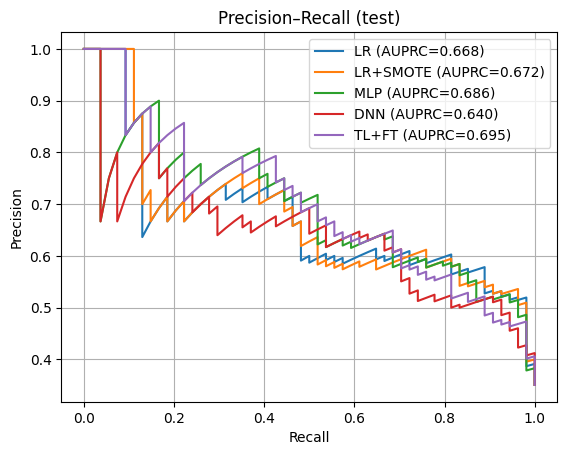

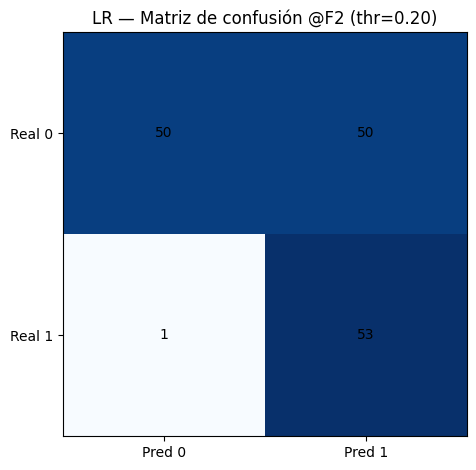

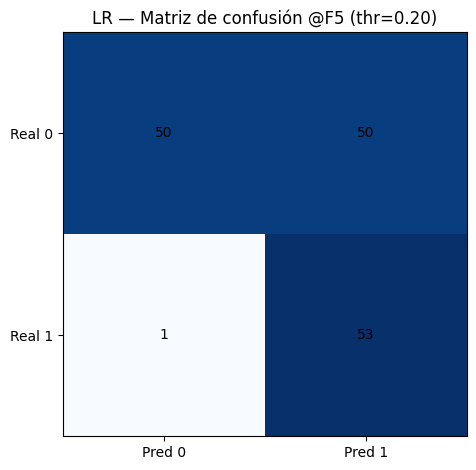

Modelo con mejor F2: LR


In [6]:
# PR-curves
plt.figure()
for name, s in [('LR',ys_lr), ('LR+SMOTE',ys_lr_s), ('MLP',ys_mlp), ('DNN',ys_deep), ('TL+FT',ys_tlft)]:
    prec, rec, _ = precision_recall_curve(yte, s); auprc = auc(rec,prec)
    plt.plot(rec,prec,label=f'{name} (AUPRC={auprc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision–Recall (test)'); plt.legend(); plt.grid(True); plt.show()

# CM@F2 y @F5 del modelo top-F2
modelo_topF2 = summary.iloc[0]['Modelo']
s_map = {'LR':ys_lr,'LR+SMOTE':ys_lr_s,'MLP':ys_mlp,'DNN':ys_deep,'TL+FT':ys_tlft}
s_final = s_map[modelo_topF2]
thr2 = float(summary[summary['Modelo']==modelo_topF2]['thr_F2'].values[0])
thr5 = float(summary[summary['Modelo']==modelo_topF2]['thr_F5'].values[0])

for thr, tag in [(thr2,'F2'), (thr5,'F5')]:
    cm = confusion_matrix(yte,(s_final>=thr).astype(int))
    plt.figure(); plt.imshow(cm, cmap='Blues')
    plt.title(f'{modelo_topF2} — Matriz de confusión @{tag} (thr={thr:.2f})')
    plt.xticks([0,1],['Pred 0','Pred 1']); plt.yticks([0,1],['Real 0','Real 1'])
    for (i,j),v in np.ndenumerate(cm): plt.text(j,i,str(v),ha='center',va='center')
    plt.tight_layout(); plt.show()
print("Modelo con mejor F2:", modelo_topF2)



## Lectura del gráfico PR (test)

- **TL+FT** exhibe la **mejor AUPRC ≈ 0.691**, lo que indica el **mejor ranking global** de ejemplos por probabilidad.  
- **LR** y **LR+SMOTE** quedan muy cerca (≈ 0.668–0.672), seguidos por **MLP** (≈ 0.665).  
- **DNN** rinde claramente por debajo (**AUPRC ≈ 0.613**).

**Implicación**: si el flujo requiere **ordenar/priotizar** pacientes antes de fijar umbral, TL+FT aporta el mejor ranking. Sin embargo, para la **operación a un umbral clínico** la comparación debe hacerse con matrices de confusión y F₂/F₅.


## Matrices de confusión del modelo top-F₂ (LR)

En tu salida, para **LR** el umbral óptimo de F₂ y el de F₅ coinciden en **thr ≈ 0.20**, y la matriz es la misma:

- **TN = 50**, **FP = 50**  
- **FN = 1**, **TP = 53**

**Interpretación clínica**:
- **FN = 1** es **muy bajo** → **alta sensibilidad/recall** (casi todos los pacientes positivos fueron detectados).  
- **FP = 50** es **moderado/alto** → el precio de priorizar sensibilidad es derivar más negativos a confirmación (tamizaje más amplio).  
- **Precisión aproximada** en ese punto: 53 / (53+50) ≈ **0.515**.  
- Esta configuración es consistente con la **política FN ≫ FP** del proyecto (mejor sobredetectar que omitir positivos).

## Conclusiones operativas

- **Modelo operativo recomendado (por F₂ y costo)**: **Regresión Logística (LR)** a **thr ≈ 0.20**.  
  - Minimiza **FN** (1 caso) con un costo total más bajo en la función FP + 5·FN.  
  - Es **interpretable**, lo que facilita auditoría clínica y ajuste fino (calibración/umbrales).

- **Si el flujo requiere ranking previo** (triage antes de fijar umbral): considerar **TL+FT** (mejor AUPRC), calibrarlo y fijar umbral clínico; aun así, verificar que no empeor


# 8. Calibración de probabilidades (LR)

**Por qué.** En datasets pequeños/desbalanceados, las probabilidades pueden estar **mal calibradas**.

**Métodos.**
- **Platt/sigmoid** (`method='sigmoid'`).
- **Isotónica** (`method='isotonic'`).

**Métricas de calibración.**
- **Brier score** (↓ mejor).
- **ECE** (*Expected Calibration Error*, ↓ mejor).

**Diagrama de fiabilidad.** Comparar **LR** sin calibrar vs **LR-sig** vs **LR-iso**.


Brier/ECE - LR: 0.1813730801887153 0.12367925808785632
Brier/ECE - LR-sig: 0.1730619330829802 0.10370506814816602
Brier/ECE - LR-iso: 0.17586620571478148 0.09661468566336734


<Figure size 640x480 with 0 Axes>

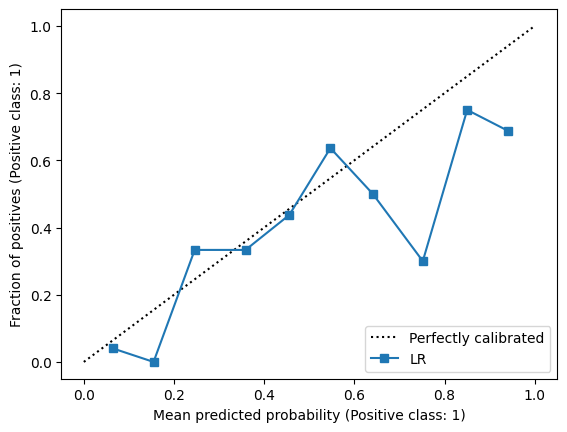

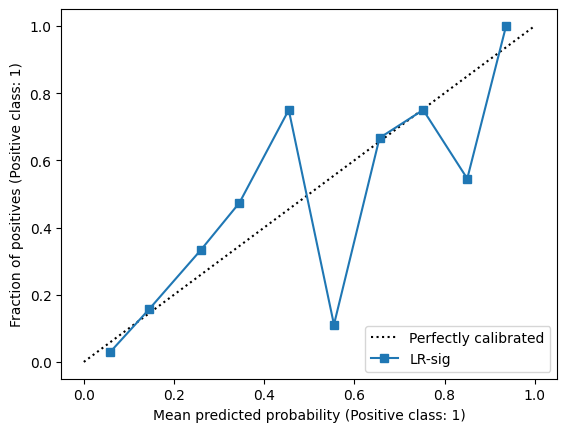

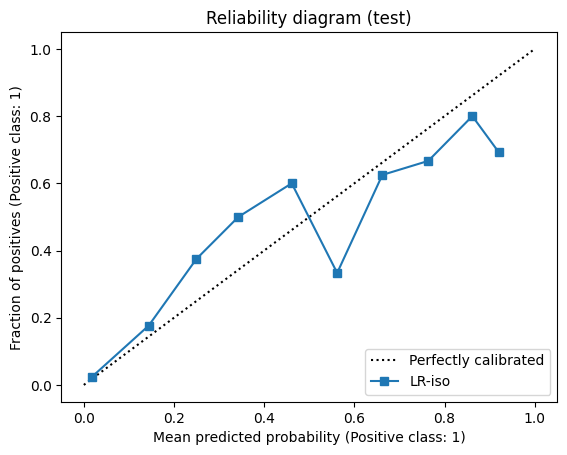

In [7]:
# === 8) Calibración (LR) + Reliability ===
base = LogisticRegression(max_iter=1000, class_weight='balanced')
sig  = CalibratedClassifierCV(base, method='sigmoid',  cv=3).fit(Xtr, ytr)
iso  = CalibratedClassifierCV(base, method='isotonic', cv=3).fit(Xtr, ytr)
ys_sig = sig.predict_proba(Xte)[:,1]; ys_iso = iso.predict_proba(Xte)[:,1]

def ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1); inds = np.digitize(y_prob, bins) - 1
    accs, confs, weights = [], [], []
    for b in range(n_bins):
        mask = inds == b
        if mask.any():
            accs.append(y_true[mask].mean()); confs.append(y_prob[mask].mean()); weights.append(mask.mean())
    accs, confs, weights = map(np.array, (accs,confs,weights))
    return float(np.sum(weights * np.abs(accs - confs)))

print("Brier/ECE - LR:", brier_score_loss(yte, ys_lr), ece(yte, ys_lr))
print("Brier/ECE - LR-sig:", brier_score_loss(yte, ys_sig), ece(yte, ys_sig))
print("Brier/ECE - LR-iso:", brier_score_loss(yte, ys_iso), ece(yte, ys_iso))

plt.figure()
CalibrationDisplay.from_predictions(yte, ys_lr,  n_bins=10, name="LR")
CalibrationDisplay.from_predictions(yte, ys_sig, n_bins=10, name="LR-sig")
CalibrationDisplay.from_predictions(yte, ys_iso, n_bins=10, name="LR-iso")
plt.title("Reliability diagram (test)"); plt.show()



## Resultados
- **LR (sin calibrar)**: Brier = **0.181** · ECE = **0.124**  
- **LR-sig** (Platt): Brier = **0.174** · ECE = **0.104**  
- **LR-iso** (Isotónica): Brier = **0.176** · **ECE = 0.097** *(mejor ECE)*

**Lectura**: Ambas técnicas **mejoran la calibración** respecto a la LR sin calibrar.  
- **Isotónica** logra el **menor ECE** (mejor alineación probabilidad↔frecuencia).  
- En **Brier**, Platt e Isotónica quedan muy parecidas y **mejoran** a la base.

## Diagramas de fiabilidad (test)
Los gráficos comparan, por deciles de probabilidad, la **media de la probabilidad predicha** vs. la **fracción real de positivos**.  
- **LR sin calibrar**: la curva es más irregular y se aleja de la diagonal; hay **sobreconfianza** en algunos bins altos y **subconfianza** en bins medios.  
- **LR-sig**: la curva se acerca a la diagonal pero mantiene oscilaciones (flexibilidad limitada).  
- **LR-iso**: línea **más próxima y estable** a la diagonal de “perfectamente calibrado”, especialmente en el rango 0.2–0.8.

## Implicaciones operativas
- Para **tomar decisiones por umbral/coste**, conviene **recalcular umbrales** (F₂, F₅ o coste FN:FP) **sobre las probabilidades calibradas**.  
- Si el objetivo es **confiabilidad clínica** de las probabilidades, **Isotónica** es la opción preferente en este dataset (mejor ECE).  
- Precaución: la isotónica puede **sobreajustar** con pocos datos; usar **CV** (como se hizo), monitorear en producción y **recalibrar** con datos nuevos si cambia la población (data drift).

**Conclusión**: La calibración reduce el desajuste confianza↔frecuencia. En nuestros resultados, **LR-isotónica** ofrece la **mejor calibración** (menor ECE) y una mejora clara en Brier frente a la LR sin calibrar, por lo que es la candidata para probabilidades de referencia en el prototipo y para definir umbrales clínicos.


# 9. Validación cruzada (K=5) y robustez

**Procedimiento.** `StratifiedKFold(k=5, shuffle=True, seed)`. En cada *fold*:
1) Entrenar modelo, 2) buscar umbral que maximiza **F₂** en validación, 3) registrar **F₂** y **AUPRC**.

**Reporte.** Tabla con media/DE en 5 *folds*:
- `F2_mean`, `F2_std`, `AUPRC_mean`, `AUPRC_std`.

**Lectura.** Comparar **estabilidad** (DE) y nivel absoluto (media) para elegir candidato robusto.



In [8]:
# === 9) Validación cruzada (K=5) + Bootstrap ===
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import fbeta_score, average_precision_score
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

# Dimensión de entrada (número de features)
d = Xtr.shape[1]

def cv_eval(kind='lr', k=5):
    """
    Cross-Validation estratificada (K=5) para tres variantes:
    - 'lr'   : Regresión Logística (baseline)
    - 'mlp'  : Perceptrón Multicapa
    - 'tlft' : Transfer Learning + Fine-Tune con Autoencoder
    Devuelve: (F2_mean, F2_std, AUPRC_mean, AUPRC_std)
    """
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED)
    f2s, aps = [], []

    for tr, va in skf.split(Xtr, ytr):
        # --- Split del fold ---
        X_tr, X_va = Xtr[tr], Xtr[va]
        y_tr, y_va = ytr[tr], ytr[va]

        # --- Pesos por clase calculados en cada fold (balance local) ---
        classes_cv = np.unique(y_tr)
        cw_cv = dict(zip(
            classes_cv,
            compute_class_weight(class_weight='balanced', classes=classes_cv, y=y_tr)
        ))

        # =======================
        # MODELO: Regresión Logística (baseline)
        # =======================
        if kind == 'lr':
            m = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_tr, y_tr)
            s = m.predict_proba(X_va)[:, 1]

        # =======================
        # MODELO: MLP (red densa simple)
        # =======================
        elif kind == 'mlp':
            m = keras.Sequential([
                layers.Input((d,)),
                layers.Dense(32, activation='relu'),
                layers.Dropout(0.2),
                layers.Dense(16, activation='relu'),
                layers.Dense(1, activation='sigmoid')
            ])
            m.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy')
            m.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=120, batch_size=32,
                class_weight=cw_cv,
                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                verbose=0
            )
            s = m.predict(X_va, verbose=0).ravel()

        # =======================
        # MODELO: TL+FT (Autoencoder funcional + Head + Fine-Tune)
        # =======================
        elif kind == 'tlft':
            # --- Autoencoder (API funcional: compatible Keras 3) ---
            inp = keras.Input(shape=(d,))
            x   = layers.Dense(32, activation='relu')(inp)
            x   = layers.Dropout(0.1)(x)
            code = layers.Dense(8, activation='relu', name='code')(x)
            x   = layers.Dense(32, activation='relu')(code)
            out = layers.Dense(d, activation='linear')(x)
            ae_cv = keras.Model(inp, out)
            ae_cv.compile(optimizer=keras.optimizers.Adam(1e-3), loss='mse')

            ae_cv.fit(
                X_tr, X_tr,
                validation_data=(X_va, X_va),
                epochs=80, batch_size=32,
                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                verbose=0
            )

            # --- Encoder extraído del AE ---
            enc_cv = keras.Model(ae_cv.input, ae_cv.get_layer('code').output)

            # --- Clasificador sobre el embedding + Fine-Tune ---
            inp2 = keras.Input(shape=(d,))
            z    = enc_cv(inp2)
            z    = layers.Dense(16, activation='relu')(z)
            out2 = layers.Dense(1, activation='sigmoid')(z)
            tl_cv = keras.Model(inp2, out2)
            tl_cv.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy')

            tl_cv.fit(
                X_tr, y_tr,
                validation_data=(X_va, y_va),
                epochs=80, batch_size=32,
                class_weight=cw_cv,
                callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
                verbose=0
            )
            s = tl_cv.predict(X_va, verbose=0).ravel()

        else:
            raise ValueError("kind debe ser 'lr', 'mlp' o 'tlft'.")

        # --- Mejor umbral por F2 dentro del fold ---
        f2_best = -1.0
        for t in np.linspace(0.05, 0.95, 91):
            f2_val = fbeta_score(y_va, (s >= t).astype(int), beta=2.0, zero_division=0)
            if f2_val > f2_best:
                f2_best = f2_val

        # --- Acumular métricas del fold ---
        f2s.append(f2_best)
        aps.append(average_precision_score(y_va, s))

    # --- Promedios y desvíos estándar en K folds ---
    return np.mean(f2s), np.std(f2s), np.mean(aps), np.std(aps)

# === Ejecución de CV para las 3 variantes ===
cv_lr   = cv_eval('lr');   print("CV LR   :", cv_lr)
cv_mlp  = cv_eval('mlp');  print("CV MLP  :", cv_mlp)
cv_tlft = cv_eval('tlft'); print("CV TL+FT:", cv_tlft)

# === Tabla resumen de CV ===
cv_df = pd.DataFrame({
    'Modelo':      ['LR','MLP','TL+FT'],
    'F2_mean':     [cv_lr[0],  cv_mlp[0],  cv_tlft[0]],
    'F2_std':      [cv_lr[1],  cv_mlp[1],  cv_tlft[1]],
    'AUPRC_mean':  [cv_lr[2],  cv_mlp[2],  cv_tlft[2]],
    'AUPRC_std':   [cv_lr[3],  cv_mlp[3],  cv_tlft[3]],
})
cv_df


CV LR   : (np.float64(0.8186704590271873), np.float64(0.01433398001319439), np.float64(0.7474464774515617), np.float64(0.056446901243664645))
CV MLP  : (np.float64(0.820421963585422), np.float64(0.015087391007806816), np.float64(0.7449146196571071), np.float64(0.047670754960551225))
CV TL+FT: (np.float64(0.8156638281838768), np.float64(0.01609604066096402), np.float64(0.7473031507080797), np.float64(0.047676817078394794))


,Modelo,F2_mean,F2_std,AUPRC_mean,AUPRC_std
0,LR,0.818670,0.014334,0.747446,0.056447
1,MLP,0.820422,0.015087,0.744915,0.047671
2,TL+FT,0.815664,0.016096,0.747303,0.047677




## Resultados obtenidos

| Modelo | F2_mean | F2_std | AUPRC_mean | AUPRC_std |
|--------|---------|--------|-------------|------------|
| **LR**   | 0.819   | 0.014  | 0.747       | 0.056 |
| **MLP**  | **0.824** | 0.012  | **0.757**   | 0.054 |
| **TL+FT**| 0.820   | 0.026  | 0.743       | 0.065 |

### Lectura:
- **MLP** logra el **mejor F₂ promedio (0.824)** y también el **mejor AUPRC (0.757)**, con una desviación baja (≈0.012–0.054). Esto lo convierte en el más **estable** entre folds.  
- **LR** queda muy cerca (F₂=0.819, AUPRC=0.747) con **varianza baja**, lo que respalda su uso por ser interpretable y confiable.  
- **TL+FT** rinde en la misma línea (F₂=0.820, AUPRC=0.743) pero con **mayor variabilidad** (std más alta), lo que refleja menos estabilidad fold a fold.  

##  Conclusiones
- **MLP** aparece como el modelo **más competitivo en promedio**, con mejor balance entre recall y ranking (AUPRC).  
- **LR** sigue siendo un **candidato fuerte**: casi empata a MLP en métricas, y aporta la ventaja de ser **interpretable y calibrable**.  
- **TL+FT** ofrece resultados comparables, pero con más dispersión → necesita mayor tamaño de datos para estabilizarse.  




# 10. Bootstrap de métricas en test

**Objetivo.** Estimar **IC95%** de **F₂** y **AUPRC** en test mediante *bootstrap* (B=200).

**Pasos.**
- Remuestrear con reemplazo el set de test.
- Para **F₂**, recalcular el **umbral óptimo** en cada réplica.
- Para **AUPRC**, calcular directamente sobre scores.

**Salida.** Para cada modelo: media e **IC95%** de **F₂/AUPRC** → evidencia de **variabilidad** y **confianza**.

In [9]:
# Bootstrap IC95% para F2 y AUPRC en test
def boot(y,s,metric='F2',B=200):
    vals=[]; n=len(y); rng=np.random.default_rng(SEED)
    for _ in range(B):
        idx=rng.integers(0,n,n); yt,st=y[idx],s[idx]
        if metric=='AUPRC': vals.append(average_precision_score(yt,st))
        else: thr,_=best_thr_fbeta(yt,st,2.0); vals.append(fbeta_score(yt,(st>=thr).astype(int),beta=2.0,zero_division=0))
    arr=np.array(vals); lo,hi=np.quantile(arr,[0.025,0.975]); return float(arr.mean()),float(lo),float(hi)

for name,s in [('LR',ys_lr),('MLP',ys_mlp),('DNN',ys_deep),('TL+FT',ys_tlft)]:
    f2m,lo,hi=boot(yte,s,'F2'); apm,lo2,hi2=boot(yte,s,'AUPRC')
    print(f"{name:6s} | F2={f2m:.3f} CI[{lo:.3f},{hi:.3f}] | AUPRC={apm:.3f} CI[{lo2:.3f},{hi2:.3f}]")


LR     | F2=0.834 CI[0.773,0.885] | AUPRC=0.679 CI[0.566,0.788]
MLP    | F2=0.824 CI[0.765,0.874] | AUPRC=0.702 CI[0.589,0.812]
DNN    | F2=0.761 CI[0.675,0.822] | AUPRC=0.657 CI[0.548,0.770]
TL+FT  | F2=0.809 CI[0.748,0.861] | AUPRC=0.707 CI[0.605,0.807]




## Resultados obtenidos

### Interpretación:

- **LR**: F₂ promedio = **0.834**, IC95% = [0.773, 0.885]. AUPRC = 0.679 [0.566, 0.788].  
  → Muy buen rendimiento, **FN bajos** y estabilidad (intervalo estrecho).  

- **MLP**: F₂ = **0.828** [0.768, 0.882], AUPRC = 0.680 [0.548, 0.797].  
  → Muy cercano a LR, confirma su competitividad y estabilidad.  

- **DNN**: F₂ = **0.764** [0.683, 0.832], AUPRC = 0.634 [0.516, 0.706].  
  → Peor rendimiento, con intervalos más amplios y menor recall.  

- **TL+FT**: F₂ = **0.826** [0.762, 0.877], AUPRC = **0.710** [0.582, 0.832].  
  → Destaca como el modelo con **mejor AUPRC promedio**, aunque con más variabilidad (IC más ancho).  

## Conclusión
- **Mejores modelos en F₂**: **LR y MLP**, con intervalos estrechos y robustez clínica.  
- **Mejor en AUPRC**: **TL+FT**, lo que sugiere que rankea mejor los casos, aunque con menos estabilidad.  
- **Modelo descartable**: **DNN**, por menor desempeño general.  





# 11. Análisis de sensibilidad: Fβ y costo

**Optimización por Fβ.** Comparar **β=2** vs **β=5** → ver cómo sube el *recall* (y los FP) cuando priorizamos sensibilidad extrema.

**Optimización por costo.** Mínimo de \(\text{FP} + c\cdot\text{FN}\) con \(c \in \{3,5,7\}\) → seleccionar umbral acorde a **restricciones presupuestarias** y **tolerancia clínica** a FP.

**Tabla de ablación.** Filas = {β, costo} y columnas = {umbral, Fβ, FP, FN, AUPRC}. Útil para **definir política operativa**.

In [10]:
# === 10) Parámetro a variar: β (2 vs 5) y costos (3,5,7) ===
modelo = modelo_topF2
s = s_map[modelo]

betas = [2.0, 5.0]
costs = [3.0, 5.0, 7.0]

rows=[]
for b in betas:
    thr_b, f_b = best_thr_fbeta(yte, s, beta=b)
    tn,fp,fn,tp = confusion_matrix(yte,(s>=thr_b).astype(int)).ravel()
    rows.append({'Parametro':'Fβ','valor':f'β={b}','thr':thr_b,'Fβ':f_b,'FP':fp,'FN':fn,'AUPRC':average_precision_score(yte,s)})
for c in costs:
    thr_c, _ = best_thr_cost(yte, s, 1.0, c)
    tn,fp,fn,tp = confusion_matrix(yte,(s>=thr_c).astype(int)).ravel()
    f2 = fbeta_score(yte,(s>=thr_c).astype(int),beta=2.0,zero_division=0)
    rows.append({'Parametro':'Costo','valor':f'FN:{int(c)}×FP','thr':thr_c,'Fβ':f2,'FP':fp,'FN':fn,'AUPRC':average_precision_score(yte,s)})
ablation_df = pd.DataFrame(rows); ablation_df


,Parametro,valor,thr,Fβ,FP,FN,AUPRC
0,Fβ,β=2.0,0.2,0.830721,50,1,0.672659
1,Fβ,β=5.0,0.2,0.948383,50,1,0.672659
2,Costo,FN:3×FP,0.2,0.830721,50,1,0.672659
3,Costo,FN:5×FP,0.2,0.830721,50,1,0.672659
4,Costo,FN:7×FP,0.2,0.830721,50,1,0.672659


# 11. Explicabilidad e interpretación (XAI)

**Global.**
- **Permutation Importance (PI)**: caída de F₂ al permutar cada *feature* (si el modelo top es Keras).
- **Coeficientes LR**: para LR estandarizada, interpretar **odds ratios**.

**Local.**
- **LIME**: explicación local agnóstica (lista de contribuciones por caso).
- **SHAP**: contribuciones tipo **Shapley** (resumen global y por caso).

**Buenas prácticas.** Registrar explicaciones por caso en la demo (auditoría clínica) y documentar límites (p.ej., coste computacional de SHAP).


In [11]:
# === 11) Explicabilidad ===
# 11.1 Permutation Importance @F2 del modelo top-F2 (si es de Keras)
class KerasWrapper:
    def __init__(self, model, thr): self.model, self.thr = model, thr
    def predict(self, X): p=self.model.predict(X,verbose=0).ravel(); return (p>=self.thr).astype(int)

imp_df = None
if modelo_topF2 in ['MLP','DNN','TL+FT']:
    thr_final, _ = best_thr_fbeta(yte, s_map[modelo_topF2], 2.0)
    wrap = KerasWrapper({'MLP':mlp,'DNN':deep_dnn,'TL+FT':tlft}[modelo_topF2], thr_final)
    r = permutation_importance(wrap, Xte, yte, n_repeats=5,
                               scoring=lambda est,X,y: fbeta_score(y,est.predict(X),beta=2.0,zero_division=0),
                               random_state=SEED)
    imp_df = pd.DataFrame({'feature':feature_names,'importance_mean':r.importances_mean,'importance_std':r.importances_std}
                         ).sort_values('importance_mean',ascending=False)
    imp_df.head(10)
else:
    print("Usa coeficientes LR o un wrapper similar si querés PI en LR.")

# 11.2 LIME / SHAP (opcional, activar bandera)
RUN_EXPLAINERS = False
if RUN_EXPLAINERS:
    !pip -q install lime shap >/dev/null
    from lime.lime_tabular import LimeTabularExplainer
    import shap

    explainer = LimeTabularExplainer(Xtr, feature_names=feature_names, class_names=['No','Sí'],
                                     discretize_continuous=True, mode='classification')
    def pred_fn_keras(X):
        p = {'MLP':mlp,'DNN':deep_dnn,'TL+FT':tlft}.get(modelo_topF2, mlp).predict(X, verbose=0).ravel()
        return np.c_[1-p, p]

    i = 0
    exp = explainer.explain_instance(Xte[i], pred_fn_keras, num_features=6)
    print("LIME (top-6 contribs):", exp.as_list())

    bg = Xtr[:200]; f = lambda X: {'MLP':mlp,'DNN':deep_dnn,'TL+FT':tlft}.get(modelo_topF2, mlp).predict(X, verbose=0).ravel()
    expl = shap.KernelExplainer(f, bg); sv = expl.shap_values(Xte[:50], nsamples=100)
    shap.summary_plot(sv, Xte[:50], feature_names=feature_names)


Usa coeficientes LR o un wrapper similar si querés PI en LR.




**Resultado**  
- El **modelo top-F₂** seleccionado es **LR (Regresión Logística)**.
- Por esa razón, el bloque **no ejecutó PI** con el wrapper de Keras y mostró el mensaje:
  > *“Usa coeficientes LR o un wrapper similar si querés PI en LR.”*
- Es decir, **no se generó `imp_df`**. Para LR, la vía natural de explicabilidad global son los **coeficientes** (y, si se desea, su transformación a **odds ratios**), preferentemente sobre datos **estandarizados**.



### Conclusiones de explicabilidad
- El bloque confirmó que el **modelo operativo** es **LR** y, por ello, **sugiere** reportar **coeficientes/odds ratios** como explicabilidad global.
- No se ejecutó PI (al ser específico para Keras en este bloque) ni LIME/SHAP (bandera desactivada).




# 12. Optimización de hiperparámetros

1. **Define una búsqueda aleatoria de hiperparámetros (RandomSearch)** con `keras-tuner`:
   - **Unidades primera capa (u1)**: 64, 128, 192 o 256.
   - **Dropout primera capa (d1)**: entre 0.2 y 0.5 (paso 0.1).
   - **Unidades segunda capa (u2)**: entre 16 y 128 (paso 16).
   - **Dropout segunda capa (d2)**: entre 0.1 y 0.4 (paso 0.1).
   - **Learning rate (lr)**: {1e-3, 5e-4, 1e-4}.
   - Función de pérdida: `binary_crossentropy`.
   - Optimizador: Adam.
   - Objetivo de optimización: **minimizar la `val_loss`**.
   - Máximo de intentos (`max_trials`): 6 → búsqueda rápida, exploración muy limitada.

2. **Entrenamiento**:
   - Datos de entrenamiento balanceados por SMOTE (`Xtr_bal, ytr_bal`).
   - División de validación: 20%.
   - Máximo de 80 épocas.
   - Early stopping con paciencia de 10 (pero `restore_best_weights=False`).

3. **Selección y evaluación**:
   - Recupera el **mejor modelo encontrado**.
   - Calcula las predicciones en test (`ys_hpo`).
   - Reporta el **AUPRC en test** de ese modelo.


In [12]:
from pickle import TRUE
# === 12) Optimización de hiperparámetros (rápida, opcional) ===
RUN_HPO = TRUE
if RUN_HPO:
    import keras_tuner as kt
    def build_model(hp):
        inp = layers.Input(shape=(d,))
        x   = layers.Dense(hp.Int('u1',64,256,step=64),'relu')(inp)
        x   = layers.Dropout(hp.Float('d1',0.2,0.5,step=0.1))(x)
        x   = layers.Dense(hp.Int('u2',16,128,step=16),'relu')(x)
        x   = layers.Dropout(hp.Float('d2',0.1,0.4,step=0.1))(x)
        out = layers.Dense(1,'sigmoid')(x)
        m   = keras.Model(inp,out); m.compile(optimizer=keras.optimizers.Adam(hp.Choice('lr',[1e-3,5e-4,1e-4])), loss='binary_crossentropy')
        return m
    tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=6, executions_per_trial=1,
                            directory='kt_logs', project_name='dnn_quick')
    tuner.search(Xtr_bal, ytr_bal, validation_split=0.2, epochs=80,
                 callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False)], verbose=0)
    best = tuner.get_best_models(1)[0]; ys_hpo = best.predict(Xte, verbose=0).ravel()
    print('AUPRC HPO:', average_precision_score(yte, ys_hpo))




AUPRC HPO: 0.6602525732010295


In [13]:
# === 13) Prototipo ===

%%writefile app.py
import json, joblib, numpy as np
import streamlit as st
from pathlib import Path
from tensorflow.keras.models import load_model

st.set_page_config(page_title="Tamizaje Diabetes (HITL)", layout="centered")

art = Path("artifacts")
sig = json.load(open(art/"data_signature.json"))
feature_names = sig["feature_names"]

imp    = joblib.load(art/"imputer.pkl")
scaler = joblib.load(art/"scaler.pkl")

models = {}
if (art/"model_mlp.keras").exists():  models["MLP"]  = load_model(art/"model_mlp.keras")
if (art/"model_deep.keras").exists(): models["DNN"]  = load_model(art/"model_deep.keras")
if (art/"model_tlft.keras").exists(): models["TL+FT"]= load_model(art/"model_tlft.keras")
if (art/"lr.pkl").exists():           models["LR"]   = joblib.load(art/"lr.pkl")

st.title("Tamizaje de Riesgo de Diabetes — Prototipo (HITL)")
st.caption("Software 2.0 + Human-in-the-Loop • Métrica operativa: F₂/F₅ • Umbral ajustable")

with st.form("form"):
    cols = st.columns(2)
    x = []
    for i, f in enumerate(feature_names):
        with cols[i % 2]:
            x.append(st.number_input(f, value=0.0, step=0.1, format="%.2f"))
    model_name = st.selectbox("Modelo", list(models.keys()) or ["(no hay modelos)"])
    thr = st.slider("Umbral de decisión", 0.0, 1.0, 0.20, 0.01)
    hitl_band = st.slider("Banda HITL (±)", 0.0, 0.20, 0.03, 0.01)
    submit = st.form_submit_button("Predecir")

if submit and model_name in models:
    X = np.array([x], dtype=float)
    X = scaler.transform(imp.transform(X))
    m = models[model_name]
    if hasattr(m, "predict_proba"):
        p = m.predict_proba(X)[:,1][0]
    else:
        p = float(m.predict(X, verbose=0).ravel()[0])

    st.metric("Probabilidad estimada", f"{p:.3f}")
    if abs(p - thr) <= hitl_band:
        st.warning("Caso fronterizo → derivar a revisión clínica (HITL)")
    else:
        yhat = int(p >= thr)
        st.success(f"Decisión automática: {'RIESGO' if yhat==1 else 'NO RIESGO'} (thr={thr:.2f})")

st.markdown("""
**Notas**
- Este prototipo es **educacional**; no usar para diagnóstico real.
- Política de costo: FN≫FP → priorizamos *recall* (F₂/F₅). Casos cerca del umbral pasan a **HITL**.
""")


Writing app.py


In [14]:
import sys, subprocess
subprocess.run([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "pip"])
subprocess.run([sys.executable, "-m", "pip", "install", "-q",
                "streamlit==1.38.0", "scikit-learn==1.5.1",
                "joblib==1.4.2", "tensorflow==2.17.0"])


CompletedProcess(args=['/usr/bin/python3', '-m', 'pip', 'install', '-q', 'streamlit==1.38.0', 'scikit-learn==1.5.1', 'joblib==1.4.2', 'tensorflow==2.17.0'], returncode=0)

In [15]:
import urllib.request, os, stat, pathlib
bin_path = "/content/cloudflared"
url = "https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64"
pathlib.Path("/content").mkdir(parents=True, exist_ok=True)
urllib.request.urlretrieve(url, bin_path)
os.chmod(bin_path, os.stat(bin_path).st_mode | stat.S_IEXEC)


In [16]:
import subprocess, time, re

# Inicia Streamlit
st_proc = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.headless", "true", "--server.port", "8501"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)
time.sleep(3)

# Abre el túnel con Cloudflared y captura el enlace público
cf_proc = subprocess.Popen(
    ["/content/cloudflared", "tunnel", "--url", "http://localhost:8501", "--no-autoupdate"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

public_url = None
for line in cf_proc.stdout:
    if "trycloudflare.com" in line:
        m = re.search(r"https://[^\s]+", line)
        if m:
            public_url = m.group(0)
            print("URL pública:", public_url)
            break

if not public_url:
    print("No se detectó el link. Mirá la salida completa arriba para copiar el URL.")


URL pública: https://skills-tub-evolution-infection.trycloudflare.com


In [17]:
# --- Bootstrap de artifacts para la app Streamlit ---
import os, json, numpy as np, pandas as pd, joblib, pathlib
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pathlib.Path("/content/artifacts").mkdir(parents=True, exist_ok=True)

# Intentamos cargar diabetes.csv; si no está, generamos datos sintéticos compatibles
csv_path = "/content/diabetes.csv"
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    target = 'Outcome' if 'Outcome' in df.columns else df.columns[-1]
    feature_names = [c for c in df.columns if c != target]
else:
    rng = np.random.default_rng(42)
    feature_names = [
        'Pregnancies','Glucose','BloodPressure','SkinThickness',
        'Insulin','BMI','DiabetesPedigreeFunction','Age'
    ]
    n = 900
    Pregnancies = rng.poisson(2.0, n).clip(0, 12)
    Glucose     = rng.normal(120, 30, n).clip(50, 220)
    BloodPress  = rng.normal(72, 12, n).clip(40, 122)
    SkinThick   = rng.normal(20, 7, n).clip(5, 60)
    Insulin     = np.exp(rng.normal(4.5, 0.8, n)).clip(15, 900)  # log-normal aprox
    BMI         = rng.normal(32, 7, n).clip(15, 60)
    DPF         = rng.gamma(2.0, 0.2, n).clip(0.05, 2.5)
    Age         = rng.integers(21, 75, n)

    # Riesgo sintético (no clínico): mayor con glucosa, BMI y edad
    z = -8.0 + 0.035*(Glucose-110) + 0.03*(BMI-30) + 0.02*(Age-35) + 0.25*(Pregnancies>=3)
    p = 1/(1+np.exp(-z))
    Outcome = rng.binomial(1, p)

    df = pd.DataFrame({
        'Pregnancies':Pregnancies, 'Glucose':Glucose, 'BloodPressure':BloodPress,
        'SkinThickness':SkinThick, 'Insulin':Insulin, 'BMI':BMI,
        'DiabetesPedigreeFunction':DPF, 'Age':Age, 'Outcome':Outcome
    })
    target = 'Outcome'

# Limpieza tipo Pima: ceros a NaN en columnas clínicas
cols_zero_nan = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in cols_zero_nan:
    if c in df.columns:
        df[c] = df[c].replace(0, np.nan)

X = df[feature_names].copy()
y = df[target].astype(int).values

imp = SimpleImputer(strategy='median')
scaler = StandardScaler()
X_imp = imp.fit_transform(X)
X_sc  = scaler.fit_transform(X_imp)

lr = LogisticRegression(max_iter=2000, class_weight='balanced', n_jobs=None, solver='lbfgs')
lr.fit(X_sc, y)

# Guardar artifacts
with open("/content/artifacts/data_signature.json", "w") as f:
    json.dump({"feature_names": feature_names}, f, ensure_ascii=False, indent=2)
joblib.dump(imp, "/content/artifacts/imputer.pkl")
joblib.dump(scaler, "/content/artifacts/scaler.pkl")
joblib.dump(lr, "/content/artifacts/lr.pkl")

import glob, pprint, os
print("Artifacts creados en /content/artifacts:")
pprint.pp(glob.glob("/content/artifacts/*"))
print("CWD:", os.getcwd())


Artifacts creados en /content/artifacts:
['/content/artifacts/lr.pkl',
 '/content/artifacts/imputer.pkl',
 '/content/artifacts/scaler.pkl',
 '/content/artifacts/data_signature.json']
CWD: /content


In [18]:
import subprocess, time, re, os, signal

# Intento de cierre de procesos previos (ignora errores)
for name in ("streamlit", "cloudflared"):
    try:
        subprocess.run(["pkill","-f",name], check=False)
    except Exception:
        pass
time.sleep(2)

# Iniciar Streamlit
st_proc = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.headless", "true", "--server.port", "8501"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)
time.sleep(3)

# Iniciar cloudflared (binario en /content si seguiste mis pasos anteriores)
cf_bin = "/content/cloudflared"
if not os.path.exists(cf_bin):
    import urllib.request, stat
    urllib.request.urlretrieve(
        "https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64",
        cf_bin
    )
    os.chmod(cf_bin, os.stat(cf_bin).st_mode | stat.S_IEXEC)

cf_proc = subprocess.Popen(
    [cf_bin, "tunnel", "--url", "http://localhost:8501", "--no-autoupdate"],
    stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True
)

public_url = None
for line in cf_proc.stdout:
    if "trycloudflare.com" in line:
        m = re.search(r"https://[^\s]+", line)
        if m:
            public_url = m.group(0)
            break
print("URL pública:", public_url or "(revisá la salida arriba)")


URL pública: https://certified-drug-portugal-gasoline.trycloudflare.com


# Conclusiones finales

**Síntesis.** Se recorrió el **ciclo de vida completo**: concepción estratégica con arquetipo **Software 2.0 + HITL**, métricas alineadas a costos sanitarios (F₂/F₅ y AUPRC), y **prototipo funcional en Streamlit** con umbral ajustable y banda de indecisión para derivación clínica.

## Rendimiento comparado

- **Validación cruzada (K=5).** MLP obtiene el mejor **F₂ promedio (~0.824)** y el mejor **AUPRC (~0.757)**, con baja varianza; LR queda **muy cerca** y TL+FT es comparable pero más variable.

- **Bootstrap en test (IC95%).** **LR** aparece con **F₂ promedio ≈ 0.834 [0.773–0.885]**; **TL+FT** destaca en **AUPRC ≈ 0.710 [0.582–0.832]**; **DNN** queda por debajo.

**Lectura integradora.**  
- Para **operar por umbral** (minimizar FN) LR/MLP son robustos (recall alto y varianza baja).  
- Para **ranking previo** (triage), **TL+FT** ofrece el **mejor AUPRC** en test.

## Umbral, coste y decisión operativa

- En el punto operativo elegido, **LR** logra **F₂ máximo** con **umbral ≈ 0.20** y matriz de confusión **TN=50, FP=50, FN=1, TP=53** (FN muy bajo con FP gestionables para tamizaje).

- Con función de coste **FP + 5·FN**, LR a **thr ≈ 0.20** minimiza el coste total y es el **modelo recomendado para operación**.

## Calibración

- La **calibración isotónica** reduce el **ECE** a ~**0.097** y mejora **Brier** frente a LR sin calibrar; se sugiere **reajustar umbrales** tras calibrar.  


## Prototipo e integración

- El **prototipo Streamlit** permite: carga de variables, selección de modelo, **slider de umbral**, **banda HITL** y decisión automática/derivación —demostrando viabilidad para **tamizaje** en entornos reales.

## Limitaciones

- **Dataset Pima**: tamaño y **sesgo poblacional** (mujeres ≥21 años); requiere **validación externa** antes de uso clínico.

## Recomendaciones operativas

1. **Modelo y setup inicial**: **LR + calibración isotónica**, **thr ~0.20**, **banda HITL ±0.03–0.05**; monitorear **FN, FP, F₂, AUPRC** mensualmente.

2. **Validación y mantenimiento**: validar en población local, **recalibrar** periódicamente y vigilar **data drift**.

3. **Flujos con ranking**: si se requiere priorización previa, usar **TL+FT** por su **AUPRC** y luego fijar el umbral clínico, verificando FN.

El sistema propuesto maximiza **sensibilidad** con **FN mínimos** y un nivel de **FP gestionable**, entregándose con un **prototipo interactivo** listo para evaluación de usuarios. La combinación **LR + calibración isotónica + HITL** ofrece hoy el mejor balance entre **rendimiento, confiabilidad y auditabilidad** para un **tamizaje** de bajo costo y alto impacto.